# Problem Sheet 3


In this problem sheet, you are expected to deal with a classification problem for loan approval. You will develop ability of
- Importing the datas from either online/local data source;
- Performing feature engineering
- Demonstrating the ability to apply Gradient Boost and LSTM
- Comparing the performance of different models.

1. Import the S&P500 stocks price datas (all_stocks_5yr.csv) as pandas Dataframe into your notebook, from the source Dataset: https://www.kaggle.com/camnugent/sandp500, name this data frame as "sp500".

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

In [20]:
sp500 = pd.read_csv('all_stocks_5yr.csv')
sp500

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


2. Change the price time series into the return time series, by performing the difference of logarithm. Perform the ADF test to the new series.  

In [21]:
# Determine how many stock companies there are
num_companies = sp500['Name'].nunique()
print(f"Number of unique stock companies: {num_companies}")


# Convert close price to numeric
sp500['close'] = pd.to_numeric(sp500['close'])

# Calculate log return with transform to maintain index alignment
sp500['log_return'] = np.log(sp500['close']) - np.log(sp500.groupby('Name')['close'].transform('shift'))
log_return_series = sp500.dropna(subset=['log_return'])
print("Log Return Series:")
print(log_return_series)

# ADF test on log returns on the whole dataset
# result = adfuller(log_return_series['log_return'], maxlag=1) 
# adf_statistic = result[0]
# p_value = result[1]
# critical_values = result[4]

# print('\nADF Test Results (Log Returns):')
# print(f'ADF Statistic: {adf_statistic}')
# print(f'p-value: {p_value}')
# print('Critical Values:')
# for key, value in critical_values.items():
#     print(f'   {key}: {value}')

# Group ADF test by stock name of each company with log_return
def adf_test(x):
    result = adfuller(x.dropna())
    return pd.Series({
        'ADF Statistic': result[0],
        'p-value': result[1],
        '1% Critical': result[4]['1%'],
        '5% Critical': result[4]['5%'],
        '10% Critical': result[4]['10%']
    })

print("\n ADF Test Results by stock name of each company:")
adf_results = log_return_series.groupby('Name')['log_return'].apply(adf_test)
adf_results

Number of unique stock companies: 505
Log Return Series:
              date   open   high    low  close    volume Name  log_return
1       2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL   -0.019857
2       2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL   -0.013227
3       2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL    0.026963
4       2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL   -0.046780
5       2013-02-15  13.93  14.61  13.93  14.50  15628000  AAL    0.035806
...            ...    ...    ...    ...    ...       ...  ...         ...
619035  2018-02-01  76.84  78.27  76.69  77.82   2982259  ZTS    0.014106
619036  2018-02-02  77.53  78.12  76.73  76.78   2595187  ZTS   -0.013454
619037  2018-02-05  76.64  76.92  73.18  73.83   2962031  ZTS   -0.039179
619038  2018-02-06  72.74  74.56  72.13  73.27   4924323  ZTS   -0.007614
619039  2018-02-07  72.70  75.00  72.69  73.86   4534912  ZTS    0.008020

[618535 rows x 8 columns]

 ADF Test Results by stock 

Name               
A     ADF Statistic   -36.978891
      p-value           0.000000
      1% Critical      -3.435563
      5% Critical      -2.863842
      10% Critical     -2.567996
                         ...    
ZTS   ADF Statistic   -27.920594
      p-value           0.000000
      1% Critical      -3.435567
      5% Critical      -2.863844
      10% Critical     -2.567997
Name: log_return, Length: 2525, dtype: float64

3. Perform EDA



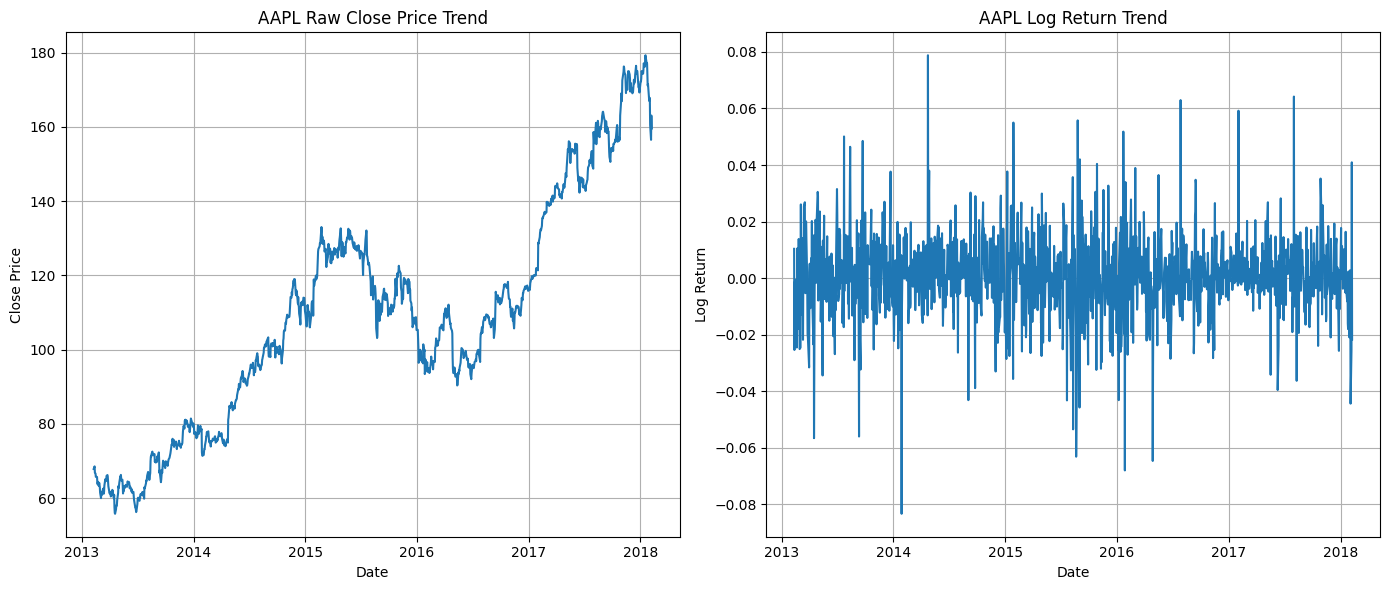

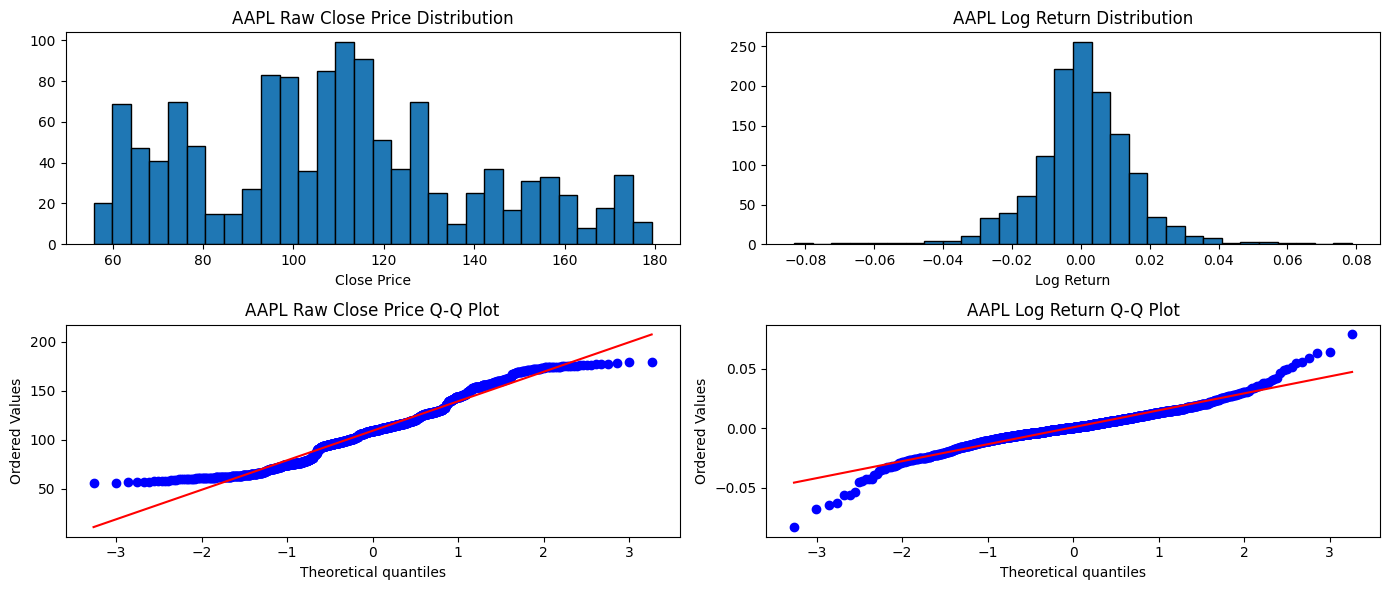

In [22]:
# Since I choose to do ADF test on each company's stock,
# I'll simply just choose AAPL for further EDA analysis as an example.
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# Prepare AAPL data
aapl = sp500[sp500['Name'] == 'AAPL'].copy()
aapl['date'] = pd.to_datetime(aapl['date'])
aapl.set_index('date', inplace=True)
aapl_log = aapl[['log_return']].dropna()


# Trend comparison
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(aapl['close'])
plt.title('AAPL Raw Close Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(aapl_log['log_return'])
plt.title('AAPL Log Return Trend')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid()
plt.tight_layout()
plt.show()



# Distribution comparison
plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
plt.hist(aapl['close'], bins=30, edgecolor='black')
plt.title('AAPL Raw Close Price Distribution')
plt.xlabel('Close Price')

plt.subplot(2, 2, 2)
plt.hist(aapl_log['log_return'], bins=30, edgecolor='black')
plt.title('AAPL Log Return Distribution')
plt.xlabel('Log Return')


# Q-Q Plot comparison
plt.subplot(2, 2, 3)
stats.probplot(aapl['close'], plot=plt)
plt.title('AAPL Raw Close Price Q-Q Plot')

plt.subplot(2, 2, 4)
stats.probplot(aapl_log['log_return'], plot=plt)
plt.title('AAPL Log Return Q-Q Plot')
plt.tight_layout()
plt.show()


* The log_return is closer to the normal distribution than the raw close_price.

<Figure size 1400x600 with 0 Axes>

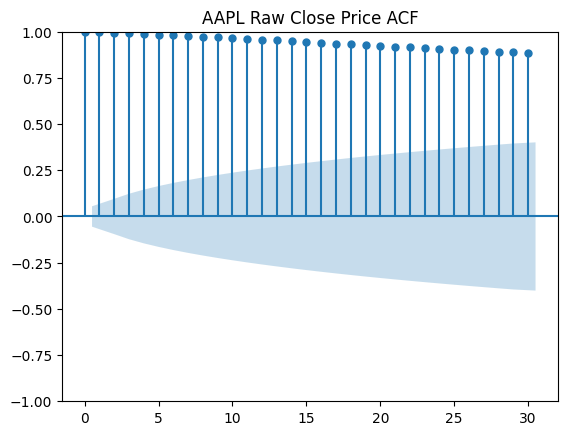

<Figure size 1400x600 with 0 Axes>

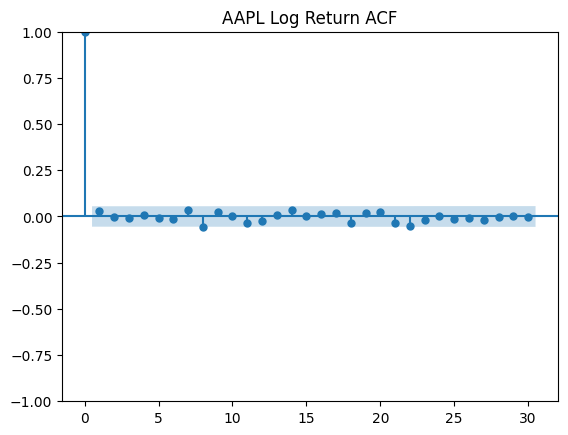

<Figure size 1400x600 with 0 Axes>

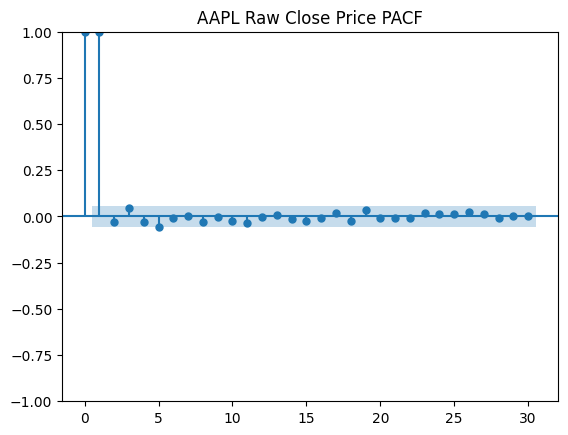

<Figure size 1400x600 with 0 Axes>

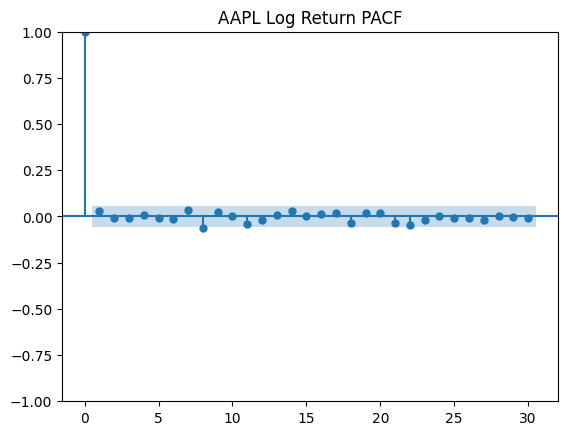

In [23]:
# ACF plots Comparison
plt.figure(figsize=(14, 6))
plot_acf(aapl['close'].dropna(), lags=30, title='AAPL Raw Close Price ACF')
plt.figure(figsize=(14, 6))
plot_acf(aapl_log, lags=30, title='AAPL Log Return ACF')
plt.show()



# PACF plots Comparison
plt.figure(figsize=(14, 6))
plot_pacf(aapl['close'].dropna(), lags=30, title='AAPL Raw Close Price PACF')
plt.figure(figsize=(14, 6))
plot_pacf(aapl_log, lags=30, title='AAPL Log Return PACF')
plt.show()




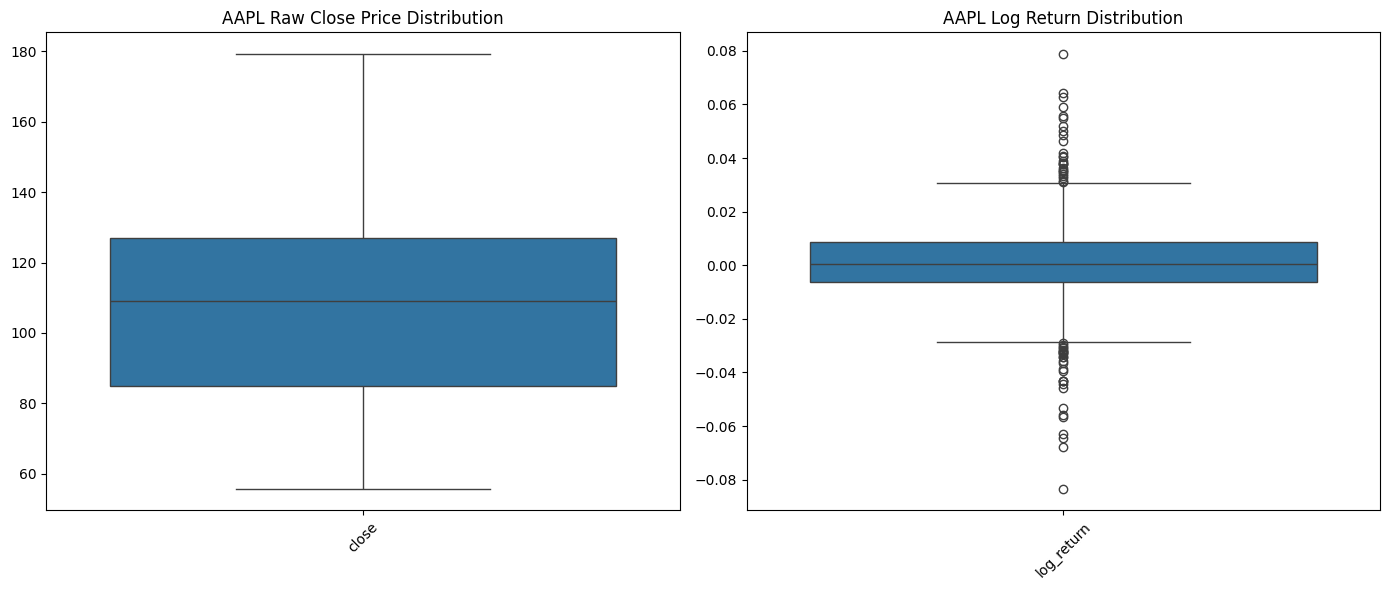


 Detected Outliers on AAPL raw close_price:

 Detected Outliers on AAPL log_return:


,log_return
date,
2013-04-17,-0.056563
2013-09-11,-0.055983
2014-01-28,-0.083302
2014-04-24,0.078794
2015-01-28,0.054993
2015-08-11,-0.053441
2015-08-21,-0.063113
2015-08-26,0.055770
2016-01-22,0.051802


In [24]:
# Plots of outliers
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=aapl[['close']])
plt.title('AAPL Raw Close Price Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=aapl_log[['log_return']])
plt.title('AAPL Log Return Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# Outlier detection print as DataFrame
z_scores = np.abs(stats.zscore(aapl[['log_return']]))
outliers_raw = aapl[(z_scores > 3.5).any(axis=1)]
print("\n Detected Outliers on AAPL raw close_price:")
outliers_raw

z_scores = np.abs(stats.zscore(aapl_log[['log_return']]))
outliers = aapl_log[(z_scores > 3.5).any(axis=1)]
print("\n Detected Outliers on AAPL log_return:")
outliers

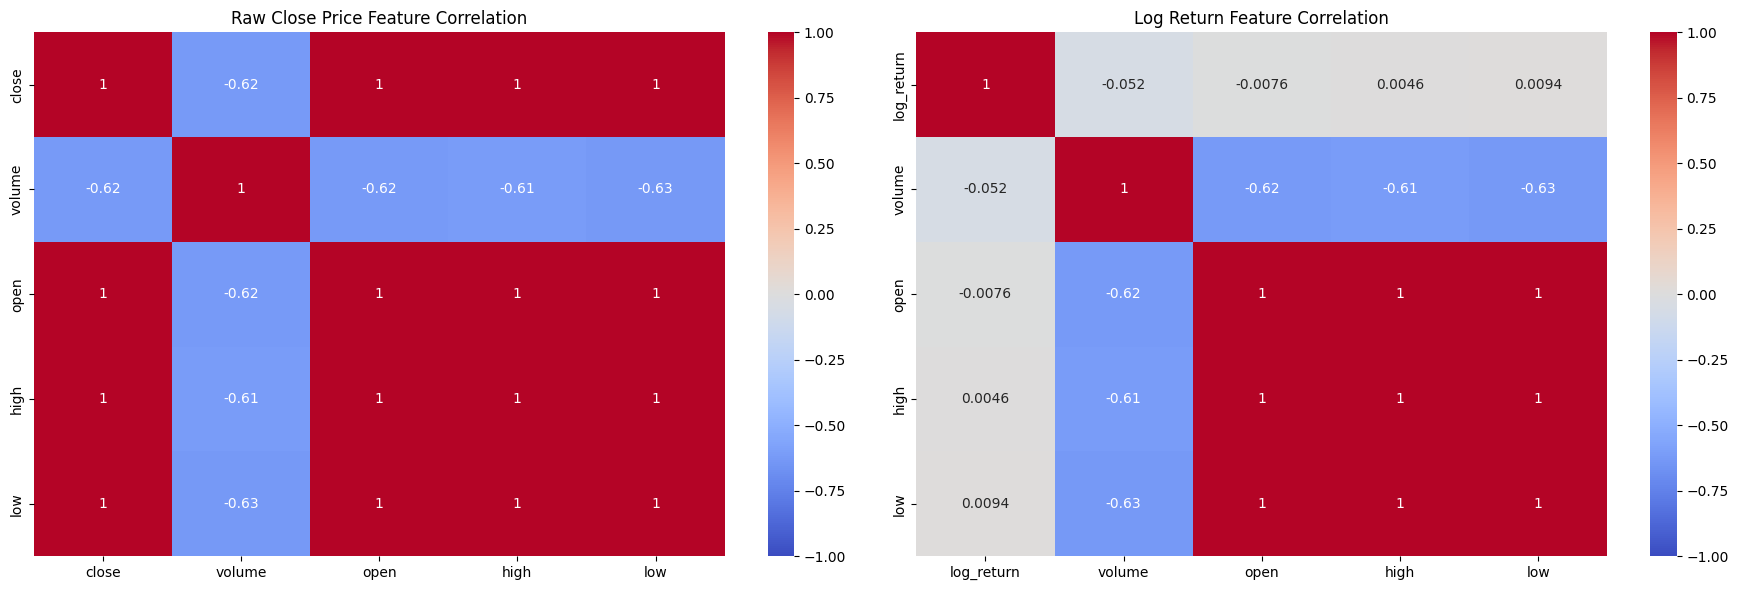

In [25]:
# Feature correlation comparison heat map
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
corr_matrix_raw = aapl[['close', 'volume', 'open', 'high', 'low']].corr()
sns.heatmap(corr_matrix_raw, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Raw Close Price Feature Correlation')

plt.subplot(1, 2, 2)
corr_matrix_log = aapl[['log_return', 'volume', 'open', 'high', 'low']].corr()
sns.heatmap(corr_matrix_log, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Log Return Feature Correlation')
plt.tight_layout()
plt.show()

* The raw price heat map shows that the price indicators are highly correlated and have obvious time series dependence.
* However the second map shows that the correlations among various variables are significantly reduced, making it more suitable for statistical modeling and predictive analysis. 
* This comparison verifies that logarithmic transformation can effectively eliminate the dependence problem of financial time series.

4.  Associate to each day's closed price the following


*   Moving average of 5 days, 10 days, 30 days, 60 days.
*   Relative strength index
*   On-balance volume





In [26]:
def q4(df):
    # Moving Averages
    df['MA_5'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(5).mean())
    df['MA_10'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(10).mean())
    df['MA_30'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(30).mean())
    df['MA_60'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(60).mean())
    
    # Relative Strength Index (RSI)
    delta = df.groupby('Name')['close'].transform(lambda x: x.diff())
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.groupby(df['Name']).transform(lambda x: x.rolling(14).mean())
    avg_loss = loss.groupby(df['Name']).transform(lambda x: x.rolling(14).mean())
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # On-Balance Volume (OBV)
    df['OBV'] = df.groupby('Name', group_keys=False).apply(
        lambda x: (np.sign(x['close'].diff()) * x['volume']).fillna(0).cumsum(), include_groups=False)
    
    return df
sp500_new = q4(sp500)
sp500_new

,date,open,high,low,close,volume,Name,log_return,MA_5,MA_10,MA_30,MA_60,RSI,OBV
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,-0.019857,NaN,NaN,NaN,NaN,NaN,-8882000.0
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,-0.013227,NaN,NaN,NaN,NaN,NaN,-17008000.0
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0.026963,NaN,NaN,NaN,NaN,NaN,-6748500.0
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,-0.046780,14.426,NaN,NaN,NaN,NaN,-38628400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,0.014106,78.434,78.144,75.069333,73.011167,64.912281,107947916.0
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,-0.013454,77.772,78.160,75.202000,73.129000,56.278229,105352729.0
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,-0.039179,76.702,77.795,75.239333,73.218667,43.835616,102390698.0
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,-0.007614,75.686,77.363,75.272333,73.281333,36.742424,97466375.0


5. Split the datas for training (80%) and testing (20%) respectively:




In [27]:
# Split data into training (80%) and testing (20%) sets while preserving time order
# I also did this by grouping stock names to ensure that each stock's data is split correctly
def time_series_split(df, test_size):
    df = df.sort_values(['Name', 'date'])    # Sort by stock name and date
    grouped = df.groupby('Name')   # Group by stock name
    
    # Split each stock's data
    train_dfs = []
    test_dfs = []
    
    for name, group in grouped:
        # Calculate split index9
        split_idx = int(len(group) * (1 - test_size))
        
        # Split while preserving time order
        train = group.iloc[:split_idx]
        test = group.iloc[split_idx:]
        
        train_dfs.append(train)
        test_dfs.append(test)
        
    return pd.concat(train_dfs), pd.concat(test_dfs)  # Concatenate all together to only one dataframe format


# Split the data
train_data, test_data = time_series_split(sp500_new, test_size=0.2)



# Verify the split, hope they are in right time and name order!!!!!!
print(f"\nTraining set size: {len(train_data)} ")
print(f"Testing set size: {len(test_data)}")

print("\nLast row of training data:")
print(train_data[['Name', 'date']].tail(1))

print("\nFirst row of testing data:")
print(test_data[['Name', 'date']].head(1))


Training set size: 495125 
Testing set size: 123915

Last row of training data:
       Name        date
618787  ZTS  2017-02-07

First row of testing data:
      Name        date
72618    A  2017-02-08


6. Apply the XGBoost model and report the result.

In [28]:
# Data preprocessing
def clean_data(df):
    # Fill missing values by forward and backward filling within each stock group
    df = df.groupby('Name', group_keys=False).apply(lambda x: x.ffill().bfill(), include_groups=False)
    
    # Drop rows where technical indicators couldn't be calculated
    df = df.dropna(subset=['MA_5', 'MA_10', 'MA_30', 'MA_60', 'RSI', 'OBV'])
    
    # Ensure no infinite values
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    return df

train_data = clean_data(train_data)
test_data = clean_data(test_data)
# print(f"\n Training set after cleaning: {len(train_data)}")
# print(f"Testing set after cleaning: {len(test_data)}")

# Feature selection for models
features = ['MA_5', 'MA_10', 'MA_30', 'MA_60', 'RSI', 'OBV']
target = 'close'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# XGBoost Model

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100,
    random_state=42)
xgb_model.fit(X_train, y_train)

# XGBoost predictions and evaluation
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_pred)

print("\nXGBoost Model Performance:")
print(f"MSE: {xgb_mse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"R^2: {xgb_r2:.4f}")


XGBoost Model Performance:
MSE: 1295.3348
MAE: 4.0322
RMSE: 35.9908
R^2: 0.9203


7. Apply the LSTM model and report the result.

In [29]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build LSTM model
lstm_model = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),  # Input layer
    LSTM(128, return_sequences=True),  # First layer LSTM
    Dropout(0.2),  # Prevent overfitting
    LSTM(64),  # Second layer LSTM
    Dropout(0.2),  # Dropout second layer
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(1)  # Output layer
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train model
training_log = lstm_model.fit(
                        X_train_lstm, 
                        y_train, 
                        epochs=10, 
                        batch_size=32, 
                        verbose=1)

# Make predictions
lstm_pred = lstm_model.predict(X_test_lstm)

# Evaluate
lstm_mse = mean_squared_error(y_test, lstm_pred)
lstm_mae = mean_absolute_error(y_test, lstm_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test, lstm_pred)

# Model evaluation
print("\n LSTM Model Performance:")
print(f"{'MSE:  '}{lstm_mse:.4f}")
print(f"{'MAE:  '}{lstm_mae:.4f}")
print(f"{'RMSE:  '}{lstm_rmse:.4f}")
print(f"{'R^2:  '}{lstm_r2:.4f}")
# print(training_log.history['loss'])
# plt.plot(training_log.history['loss'])
# plt.title('Model Training Progress')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.show()

Epoch 1/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 555.2968
Epoch 2/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 58.0493
Epoch 3/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 55.5711
Epoch 4/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 50.6235
Epoch 5/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 50.8516
Epoch 6/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - loss: 50.1990
Epoch 7/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - loss: 49.2523
Epoch 8/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 47.3148
Epoch 9/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 45.6542
Epoch 10/10
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 44.6048
3873/3873 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

 LSTM Model Performance:
MSE:  120.9792
MAE:  1.8472
RMSE:  10.9991
R^2:  0.9926


8. Now label the daily return as being positive or negative and predict the direction of the daily market move as a classfication problem. If possible, modify the models and try to achieve an accuracy of at least 60%.

In [30]:
# XGBoost Classifier for Market Direction Prediction
# Create binary label for daily return direction (1 for positive, 0 for negative)
train_data['direction'] = (train_data['log_return'] > 0).astype(int)
test_data['direction'] = (test_data['log_return'] > 0).astype(int)

# Feature selection for classification
X_train_clf = train_data[features]
y_train_clf = train_data['direction']
X_test_clf = test_data[features]
y_test_clf = test_data['direction']

# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_clf.fit(X_train_clf, y_train_clf)

# Classification predictions and evaluation
xgb_clf_pred = xgb_clf.predict(X_test_clf)
xgb_clf_accuracy = (xgb_clf_pred == y_test_clf).mean()

print("\nXGBoost Classifier Performance:")
print(f"Accuracy: {xgb_clf_accuracy:.4f}")


XGBoost Classifier Performance:
Accuracy: 0.6115


In [31]:
# LSTM Classifier for Market Direction Prediction
# Prepare data for LSTM
scaler = MinMaxScaler()
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm_clf = X_train_clf_scaled.reshape(X_train_clf_scaled.shape[0], 1, X_train_clf_scaled.shape[1])
X_test_lstm_clf = X_test_clf_scaled.reshape(X_test_clf_scaled.shape[0], 1, X_test_clf_scaled.shape[1])

# Build LSTM classification model
lstm_clf_model = Sequential([
    Input(shape=(1, X_train_clf_scaled.shape[1])),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

lstm_clf_model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # L = -(y*log(p) + (1-y)*log(1-p))
    metrics=['accuracy']   # (TP + TN) / (TP + TN + FP + FN)
)

# Train model
training_log2 = lstm_clf_model.fit(
    X_train_lstm_clf,
    y_train_clf,
    epochs=15,
    batch_size=32,
    verbose=1
)

# Evaluate model
lstm_clf_pred_proba = lstm_clf_model.predict(X_test_lstm_clf)
lstm_clf_pred = (lstm_clf_pred_proba > 0.5).astype(int)
lstm_clf_accuracy = (lstm_clf_pred.flatten() == y_test_clf).mean()

print("\nLSTM Classifier Performance:")
print(f"Accuracy: {lstm_clf_accuracy:.4f}")

Epoch 1/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.5744 - loss: 0.6758
Epoch 2/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.5762 - loss: 0.6751
Epoch 3/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.5769 - loss: 0.6749
Epoch 4/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.5773 - loss: 0.6746
Epoch 5/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.5777 - loss: 0.6741
Epoch 6/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.5784 - loss: 0.6739
Epoch 7/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.5793 - loss: 0.6735
Epoch 8/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - accuracy: 0.5801 - loss: 0.6729
Epoch 9/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 0.5814 - loss: 0.6723
Epoch 10/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 0.5842 - loss: 0.6711
Epoch 11/15
15472/15472 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.5868 - loss: 0.67